# Pliable Lasso

In [49]:
import numpy as np
import scipy as sp
from scipy import stats, linalg
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

# add parent directory to load spmimage
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend(loc=1)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend(loc=1)
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

In [4]:
# fix the seed of random
np.random.seed(0)

In [87]:
a = np.arange(16).reshape(4,4)
b = np.ones((4,4))
c = [a[:,i].reshape(4,1) * b for i in range(4)]
b
hoge = np.ones(4)
b.dot(hoge)

In [58]:
def _soft_threshold(X: np.ndarray, thresh: float) -> np.ndarray:
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

In [99]:
def _bccd(X, Z, y, alpha=0.5):
    n_samples, n_features = X.shape[:2]
    K = Z.shape[1]
    W = [X[:, j].reshape(n_samples, 1) * Z for j in range(n_features)]
    beta = np.zeros(n_features)
    theta = np.zeros((K, n_features))
    
    lamb = 1.0
    
    # least square regression
    Ztil = np.hstack((np.ones((n_samples, 1)), Z))
    beta0_theta0 = linalg.solve(Ztil.T.dot(Ztil), Ztil.T.dot(y))
    beta0, theta0 = beta0_theta0[0], beta0_theta0[1:]
    
    for j in range(n_features):
        r = y - np.sum([beta[l] * X[:, l] + W[l].dot(theta[:, l])
                        for l in range(n_features) if l != j])
        
        if (abs(X[:, j].dot(r) / n_samples) <= (1 - alpha) * lamb
            and np.linalg.norm(_soft_threshold(W[j].T.dot(r) / n_samples, alpha * lamb))
                               <= 2 * (1 - alpha) * lamb):
            continue
            
        beta[j] = n_samples / (X[:, j]**2).sum() \
            * _soft_threshold(X[:, j].T.dot(r) / n_samples, (1 - alpha) * lamb)
        if np.linalg.norm(_soft_threshold(W[j].T.dot(r - beta[j] * X[:, j]))):
            continue
            
        while(1):
            

In [93]:
# Train and cross-validate a pliable lasso model- Gaussian case
n = 20
p = 3
nz = 3
x = np.random.normal(0, 1, (n, p))
mx = np.mean(x, axis=0)
sx = np.std(x, axis=0)
x =stats.zscore(x)
z = np.random.normal(0, 1, (n, nz))
mz = np.mean(z, axis=0)
sz = np.std(z, axis=0)
z = stats.zscore(z)
y = 4 * x[:, 0] + 5 * x[:, 0] * z[:, 2] + 3 * np.random.normal(n)
_bccd(x, z, y)

[62.85261543 67.24502621 65.12744591 63.32971893 62.17697206 60.45066865
 59.50441815 80.11462932 47.40605107 61.52056488 62.9415053  63.15108824
 63.79941872 62.82438766 62.27648157 63.36450923 62.0476287  59.05078168
 59.12508635 65.66425547]
[62.85261543 67.24502621 65.12744591 63.32971893 62.17697206 60.45066865
 59.50441815 80.11462932 47.40605107 61.52056488 62.9415053  63.15108824
 63.79941872 62.82438766 62.27648157 63.36450923 62.0476287  59.05078168
 59.12508635 65.66425547]
[62.85261543 67.24502621 65.12744591 63.32971893 62.17697206 60.45066865
 59.50441815 80.11462932 47.40605107 61.52056488 62.9415053  63.15108824
 63.79941872 62.82438766 62.27648157 63.36450923 62.0476287  59.05078168
 59.12508635 65.66425547]


## Fused Lasso

Fused Lasso minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|w_j - w_{j-1}\right|
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does fusibility. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \alpha_1I_p + \alpha_2 \left(\begin{array}{cccccc}
-1 & 1 & 0 & \ldots & 0 & 0 \\
0 & -1 & 1 & \ldots & 0 & 0 \\
\ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & -1 & 1 & 0 \\
0 & 0 & 0 & \ldots & -1 & 1
\end{array}
\right)
\right) 
$$

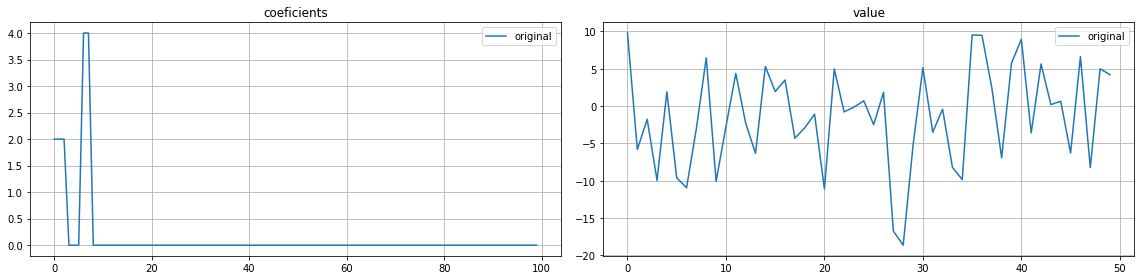

In [4]:
# input signals

n_samples = 50
n_features = 100
beta = np.zeros(n_features)
beta[0:3] = 2
beta[6:8] = 4

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [5]:
from spmimage.linear_model import FusedLassoADMM as FusedLasso

def run_fused_lasso(l1, l2):

    clf = FusedLasso(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)    
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 2.1743
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 196 ms, sys: 7.18 ms, total: 203 ms
Wall time: 206 ms


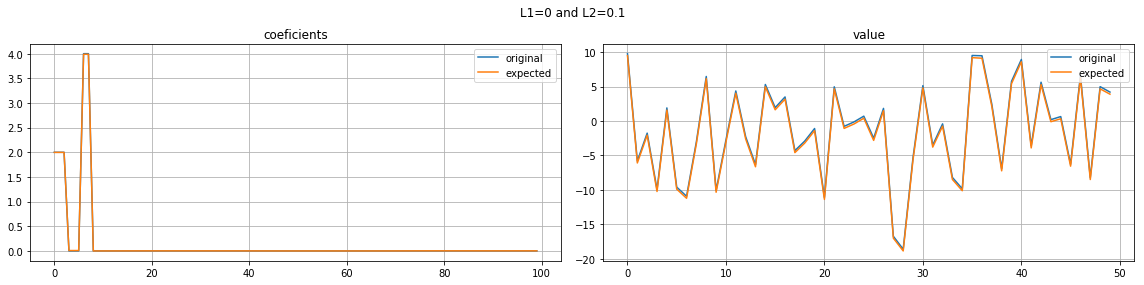

In [6]:
%%time

error, coef = run_fused_lasso(0, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

error : 2.1988
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 154 ms, sys: 7.1 ms, total: 161 ms
Wall time: 159 ms


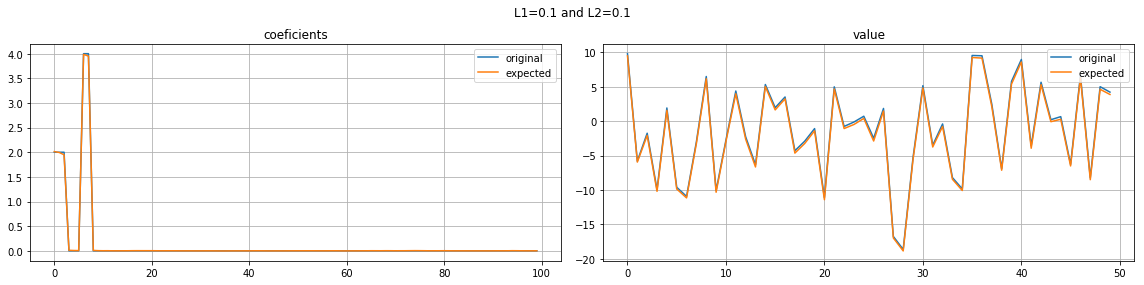

In [7]:
%%time

error, coef = run_fused_lasso(0.1, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

error : 2.1644
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 180 ms, sys: 6.65 ms, total: 186 ms
Wall time: 186 ms


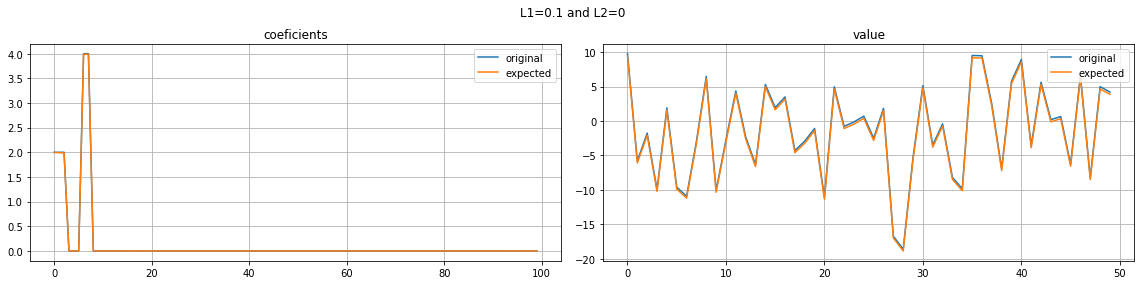

In [8]:
%%time

error, coef = run_fused_lasso(0.1, 0)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

## Trend Filtering

Trend Filtering minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|2w_j - w_{j-1} -w_{j+1}\right|
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does smoothness. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \alpha_1I_p + \alpha_2 \left(\begin{array}{cccccc}
1 & -1 & 0 & \ldots & 0 & 0 & 0\\
-1 & 2 & -1 & \ldots & 0 & 0 & 0\\
\ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & \ldots & -1 & 2 & -1 \\
0 & 0 & 0 & \ldots & 0 & -1 & 1
\end{array}
\right)
\right) 
$$

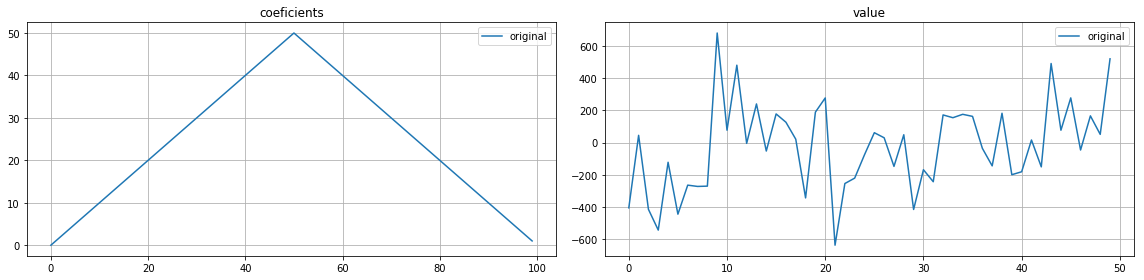

In [9]:
np.random.seed(0)

# make x
beta = [i for i in range(0, 50)] + [50 - i for i in range(0, 50)]
# make y
X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [10]:
from spmimage.linear_model import TrendFilteringADMM as TrendFiltering

def run_trend_filtering(l1, l2):
    clf = TrendFiltering(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)    
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 2.1850
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 195 ms, sys: 5.32 ms, total: 201 ms
Wall time: 214 ms


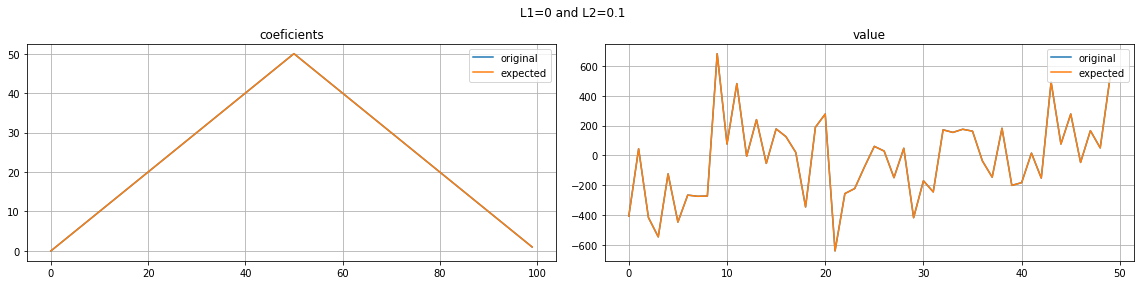

In [11]:
%%time

error, coef = run_trend_filtering(0, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

## Quadratic Trend Filtering

Quadratic Trend Filtering minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|-w_{j+1}+3w_j-3w_{j-1} + w_{j-2}\right|
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does smoothness. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \alpha_1I_p + \alpha_2 \left(\begin{array}{cccccc}
1 & -1 & 0 & 0 & \ldots & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & \ldots & 0 & 0 & 0 & 0\\
1 & -3 & 3 & -1 &  \ldots & 0 & 0 & 0 & 0\\
\ & \ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & 0 & \ldots & -1 & 3 & -3 & 1 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 & -1 & 1\\
\end{array}
\right)
\right) 
$$

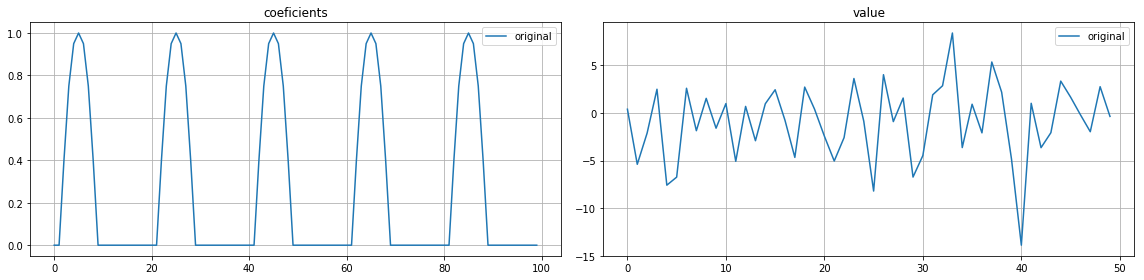

In [12]:
# input signals

n_samples = 50
n_features = 100

beta = np.array([0,0,0.4,0.75,0.95,1,0.95,0.75,0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] * 5)

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [13]:
from spmimage.linear_model.admm import QuadraticTrendFilteringADMM
def run_quadratic_trend_filtering(l1, l2):
    clf = QuadraticTrendFilteringADMM(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 6.2563
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 183 ms, sys: 8.14 ms, total: 191 ms
Wall time: 198 ms


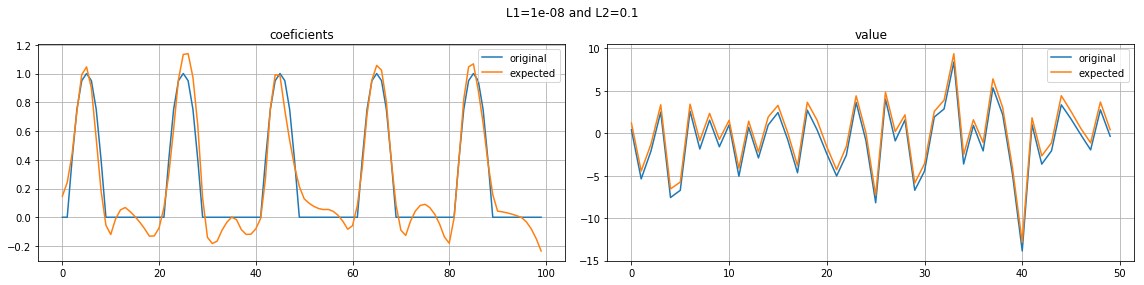

In [14]:
%%time
error, coef = run_quadratic_trend_filtering(1e-8, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))